C:\Users\luvra\AppData\Local\Temp\ipykernel_9116\2792819458.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval="1h")
[*********************100%***********************]  1 of 1 completed


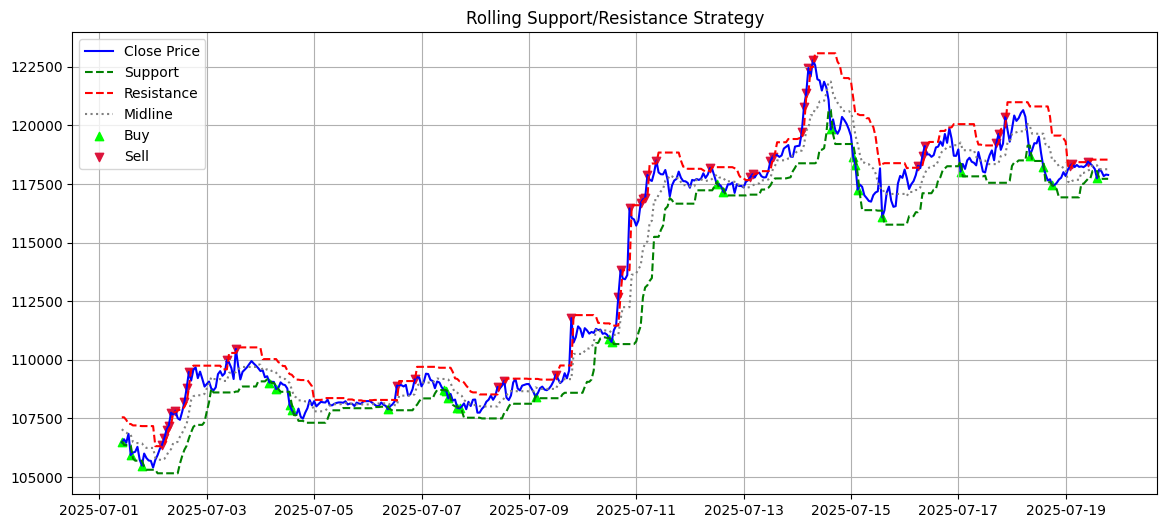

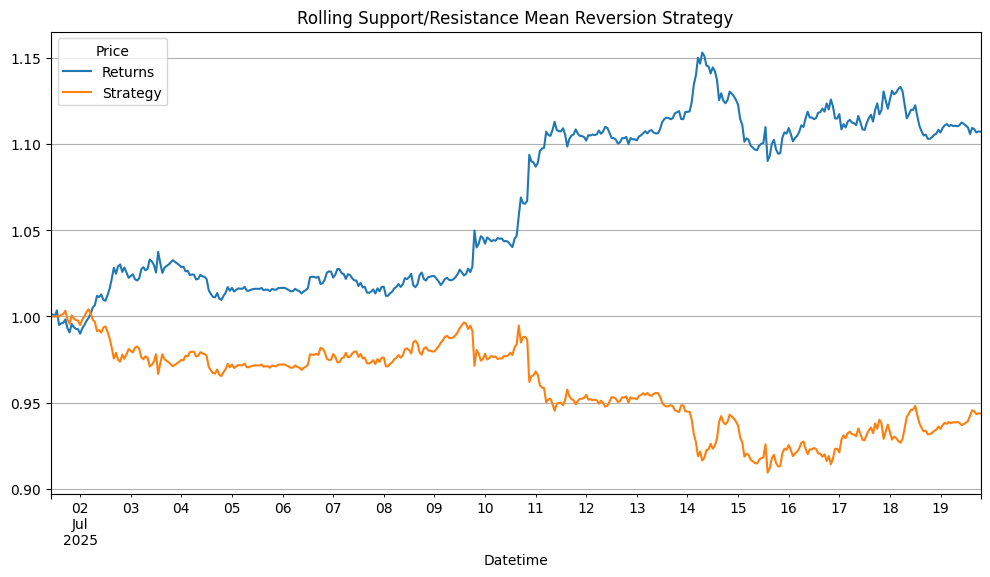

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker = "BTC-USD"
start = "2025-07-01"
end = "2025-07-20"

def download_data(start, end, ticker):
    data = yf.download(ticker, start=start, end=end, interval="1h")
    if data.empty:
        print("No data fetched. Check ticker, interval, or date range.")
        return pd.DataFrame()
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data



def compute_rolling_levels(data, window=20):
    data['Support'] = data['Low'].rolling(window).min().shift(1)
    data['Resistance'] = data['High'].rolling(window).max().shift(1)
    data['Mid'] = (data['Support'] + data['Resistance']) / 2
    return data


def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0
    data.loc[data['Close'] <= data['Support'], 'Signal'] = 1
    data.loc[data['Close'] >= data['Resistance'], 'Signal'] = -1

    # Exit: -1 to close long, +1 to close short
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = download_data(start=start, end=end, ticker=ticker)
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)


In [56]:
df["Profit or Loss"] = df["Returns"] - df.return 
df

SyntaxError: invalid syntax (3233825589.py, line 1)